In [1]:
#| default_exp training

In [2]:
#|export
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from pathlib import Path
from torch import tensor,nn
import torch.nn.functional as F

In [3]:
from fastcore.test import test_close

In [4]:
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False, threshold=1000)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray'

## Initial setup

### Data

In [5]:
with gzip.open(Path('data')/'mnist.pkl.gz', 'rb') as f: 
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
x_train, y_train, x_valid, y_valid = map(tensor, [x_train, y_train, x_valid, y_valid])

In [6]:
n,m = x_train.shape
c = y_train.max()+1
nh = 50   # hidden
v,w = x_valid.shape
n,m,int(c), v, w

(50000, 784, 10, 10000, 784)

In [7]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.layers = [nn.Linear(n_in,nh), nn.ReLU(), nn.Linear(nh,n_out)]
        
    def __call__(self, x):
        for l in self.layers: x = l(x)
        return x

In [8]:
model = Model(m, nh, c)
pred = model(x_train)
print("Pred shape:", pred.shape)
pred[:5]

Pred shape: torch.Size([50000, 10])


tensor([[-0.09, -0.21, -0.08,  0.10, -0.04,  0.08, -0.04, -0.03,  0.01,  0.06],
        [-0.07, -0.14, -0.14, -0.03, -0.00,  0.13, -0.04,  0.03,  0.04,  0.14],
        [-0.19, -0.04,  0.02,  0.21, -0.06, -0.00, -0.08, -0.01, -0.00,  0.02],
        [-0.05, -0.21, -0.07,  0.08,  0.04,  0.08, -0.10, -0.01,  0.09,  0.01],
        [-0.15, -0.19, -0.04,  0.06, -0.05,  0.15, -0.11,  0.01,  0.08,  0.05]], grad_fn=<SliceBackward0>)

## Cross entropy loss
Cross-entropy loss, also known as log loss or logistic loss, is a commonly used loss function in machine learning, especially for classification tasks. It measures the **difference between the predicted probability distribution of a model and the true probability distribution of the labels.**  
A lower cross-entropy value indicates that the predicted probability distribution is closer to the true distribution, and thus the model's predictions are more accurate. A perfect model would have a cross-entropy loss of 0.
The goal during the training of a classification model is to **minimize the cross-entropy loss**. 

First, we will need to compute the softmax of our activations. This is defined by:
$\hbox{softmax(x)}_{i} = \frac{e^{x_{i}}}{e^{x_{0}} + e^{x_{1}} + \cdots + e^{x_{n-1}}}$
<br>
or more concisely:
$\hbox{softmax(x)}_{i} = \frac{e^{x_{i}}}{\sum\limits_{0 \leq j \lt n} e^{x_{j}}}$
<br>
In practice, we will need the log of the softmax when we calculate the loss.
<br>
Below $e^{x_{i}} =$ `x.exp()`, and $ \sum\limits_{0 \leq j \lt n} e^{x_{j}}$ = `(x.exp().sum(-1,keepdim=True))`

Note that the formula $\log \left ( \frac{a}{b} \right ) = \log(a) - \log(b)$
gives a simplification when we compute the log softmax:<br>
$log(a) =$ `x` ,     $log(b) =$ `x.exp().sum(-1,keepdim=True).log()`

In cross-entropy, we don't want softmax, we want log of softmax:
We want to keep that dimension `keepdim=True` so that when we do the divided by, 
we want a trailing unit axis (for the same reason as when we did our MSE loss function).
A `sum()` with `keepdim=True` leaves a unit axis in that last position,
so we don't have to put it back to avoid the broadcasting product issue.

In [9]:
def log_softmax(x): return x - x.exp().sum(-1,keepdim=True).log()

print(log_softmax(pred))

tensor([[-2.37, -2.49, -2.36,  ..., -2.31, -2.28, -2.22],
        [-2.37, -2.44, -2.44,  ..., -2.27, -2.26, -2.16],
        [-2.48, -2.33, -2.28,  ..., -2.30, -2.30, -2.27],
        ...,
        [-2.33, -2.52, -2.34,  ..., -2.31, -2.21, -2.16],
        [-2.38, -2.38, -2.33,  ..., -2.29, -2.26, -2.17],
        [-2.33, -2.55, -2.36,  ..., -2.29, -2.27, -2.16]], grad_fn=<SubBackward0>)


### LogSumExp trick
**Problem:** Directly computing $\sum_i e^{x_i}$ can lead to overflow and precision issues if the $x_i$ are large. Floating-point representation has lower precision for numbers far from zero, making derivative calculations unreliable, potentially resulting in zero derivatives when numbers are indistinguishable.

**LogSumExp Trick:** To address this, we aim to compute $\log(\sum_i e^{x_i})$ in a numerically stable way.
<br>
Let $m = \max(x_i)$. We want to avoid calculating $e^{x_i}$ directly.
<br>
Consider subtracting $m$ from each $x_i$ in the following sum:
$\sum_i e^{x_i} = e^{x_1} + e^{x_2} + \dots + e^{x_n}$
<br>
Subtracting $m$ from each exponent changes the sum:
$\sum_i e^{x_i - m} = e^{x_1 - m} + e^{x_2 - m} + \dots + e^{x_n - m}$
<br>
Using the exponent rule $e^{a - b} = \frac{e^{a}}{e^{b}}$, 
we have $e^{x_i - m} = \frac{e^{x_i}}{e^{m}} = e^{x_i} e^{-m}$.
<br>
Therefore:
$\sum_i e^{x_i - m} = e^{-m} e^{x_1} + e^{-m} e^{x_2} + \dots + e^{-m} e^{x_n}$
<br>
Factoring out $e^{-m}$:
$\sum_i e^{x_i - m} = e^{-m} (e^{x_1} + e^{x_2} + \dots + e^{x_n}) = e^{-m} \sum_i e^{x_i}$
<br>
To recover the original sum, we multiply by $e^{m}$:
$\sum_i e^{x_i} = e^{m} \sum_i e^{x_i - m}$
<br>
Taking the logarithm of both sides gives us the LogSumExp formula:
$\log(\sum_i e^{x_i}) = \log(e^{m} \sum_i e^{x_i - m}) = \log(e^{m}) + \log(\sum_i e^{x_i - m}) = m + \log(\sum_i e^{x_i - m})$

By subtracting the maximum value $m$ from each $x_i$, we ensure that the largest exponent becomes 0, and all other exponents are negative or zero. This prevents overflow during the exponentiation and keeps the numbers within a more manageable range for floating-point arithmetic, leading to more stable derivative calculations.

See above the output of `preds[:5]` to confirm the maxs of every row in the `preds`.

In [10]:
ma = pred.max(-1)[0]
ma, ma.shape

(tensor([0.10, 0.14, 0.21,  ..., 0.14, 0.11, 0.14], grad_fn=<MaxBackward0>),
 torch.Size([50000]))

Below using the LogSumExp trick, where: 
$ \log \left ( \sum_{j=1}^{n} e^{x_{j}-a} \right) $ = `x-a[:,None]).exp().sum(-1).log()`

In [11]:
def logsumexp(x):
    a = x.max(-1)[0]  # a is as in the above formula, the max of the xj
    return a + (x - a[:,None]).exp().sum(-1).log()

This way, we will avoid an overflow when taking the exponential of a big activation. <br>
PyTorch implements this as `torch.logsumexp()`. 

In [12]:
test_close(logsumexp(pred), torch.logsumexp(pred, dim=-1))

Now reimplement `log_softmax` using `logsumexp`

In [13]:
def log_softmax(x): 
    return x - x.logsumexp(-1,keepdim=True)

sm_pred = log_softmax(pred)
sm_pred

tensor([[-2.37, -2.49, -2.36,  ..., -2.31, -2.28, -2.22],
        [-2.37, -2.44, -2.44,  ..., -2.27, -2.26, -2.16],
        [-2.48, -2.33, -2.28,  ..., -2.30, -2.30, -2.27],
        ...,
        [-2.33, -2.52, -2.34,  ..., -2.31, -2.21, -2.16],
        [-2.38, -2.38, -2.33,  ..., -2.29, -2.26, -2.17],
        [-2.33, -2.55, -2.36,  ..., -2.29, -2.27, -2.16]], grad_fn=<SubBackward0>)

### Integer array indexing
The cross entropy loss between a target $x$ and a prediction $p(x)$ is calculated as:
$ -\sum x\, \log p(x) $
<br>
However, since our targets $x$ are represented as integer indices $i$ (e.g., class labels), we can simplify the calculation. 
Instead of using the full formula, we can directly access the predicted probability of the target class using its index, i.e.,
$-\log(p_{i})$ where $i$ is the index of the desired target.
<br>
This can be done using NumPy-style [integer array indexing](https://docs.scipy.org/doc/numpy-1.13.0/reference/arrays.indexing.html#integer-array-indexing), which allows us to access specific elements in a tensor using their integer indices. 
In this case, we can use integer array indexing to directly access the predicted probability of the target class, making the calculation more efficient.
<br>
Rewritten formula: `loss = -log(predictions[target_index])`.
Using integer array indexing simplifies the cross-entropy loss calculation and makes it more computationally efficient.

In [14]:
y_train[:3]  # the first 3 target labels are:

tensor([5, 0, 4])

Above are the first three label values in `y_train`: 5, 0, and 4.
We want to find in our softmax predictions:
the 5th prediction in the zeroth row, the 0th prediction in the first row, and the 4th prediction in the 2nd (index two) row.

In [15]:
sm_pred[0,5].item(),sm_pred[1,0].item(),sm_pred[2,4].item() # the (current) predictions for the first 3 targets are:

(-2.20015025138855, -2.3723506927490234, -2.3550922870635986)

Above values are what we add up for the first rows of our loss function. 
We use an "index trick" to do it all at once.
We index using two lists: the first index is the (rows) list `[0, 1, 2]`, and the second index is `y_train[:3]`.
So the indeces are going to be `[0,5]`, `[1,0]`, and `[2,4]`,  which is the same thing as above. 

In [16]:
sm_pred[[0,1,2], y_train[:3]] # advanced indexing....

tensor([-2.20, -2.37, -2.36], grad_fn=<IndexBackward0>)

In [17]:
sm_pred.shape, sm_pred.shape[0], range(y_train.shape[0])

(torch.Size([50000, 10]), 50000, range(0, 50000))

So, the '2 list indexing' gives us what we need for cross-entropy loss.
We'll use `range(target.shape[0])` (i.e. range(50000)) as the first index,
and y_train (the target labels) as the second index. 
Taking the negative `mean` of this gives us the cross-entropy loss.

In [18]:
def nll(input, target):
    """
    Calculate the negative log likelihood (NLL) loss.

    Args:
        input (Tensor): Predicted log probabilities. Shape: (batch_size, num_classes)
        target (Tensor): True labels. Shape: (batch_size,)

    Returns:
        Tensor: NLL loss.
    """
    assert isinstance(input, torch.Tensor) and input.ndim == 2, "Input should be a 2D tensor"
    assert isinstance(target, torch.Tensor) and target.ndim == 1, "Target should be a 1D tensor"
    assert input.shape[0] == target.shape[0], "Input and target batch sizes should match"
    assert torch.all(target >= 0) and torch.all(target < input.shape[1]), "Target labels should be within valid range"

    return -input[range(target.shape[0]), target].mean()

PyTorch calls this negative log likelihood `nll` loss.

In [19]:
loss = nll(sm_pred, y_train) ; round(loss.item(),4)

2.3003

Now with PyTorch's implementation, we compute the `nll_loss`,  passing it the result of the `log_softmax`, between the predictions `pred` and the actual labels `y_train`. The result is `Ptloss`. 

In [20]:
Ptloss = F.nll_loss(F.log_softmax(pred, dim=-1), y_train); Ptloss.item()

2.300276517868042

In [21]:
test_close(Ptloss, loss, 1e-4)

In PyTorch, `F.log_softmax` and `F.nll_loss` are combined in one function, `F.cross_entropy`,
lets check that it gives us the same thing.

In [22]:
test_close(F.cross_entropy(pred, y_train), loss, 1e-5)

In above description, many confusing things go on. 
Lets look at each step, think what and why is doing it.
Experiment with different values to see what's going on.

**HW:** Reimplement `log_softmax(), nll_loss() and cross_entropy()` and compare them to PyTorch's values.

## Basic training loop

Basically the training loop repeats over the following steps:
- get the output of the model on a batch of inputs
- compare the output to the labels we have and compute a loss
- calculate the gradients of the loss with respect to every parameter of the model
- update said parameters with those gradients to make them a little bit better

Lets create a training loop.
The loss function is `F.cross_entropy`, the batch size `bs=64`. 
`xb` is the first minibatch, from 0 to 64 from the training set. 
The predictions `preds` are returned by calling the `model(xb)`, and the result shape is `[64,10]`, 
i.e., for each image in the minibatch we have 10 probabilities, one for each digit.

In [23]:
loss_func = F.cross_entropy

bs=64                 # batch size
xb = x_train[0:bs]     # a mini-batch from x of size bs
preds = model(xb)      # predictions for this mini-batch
preds.shape

torch.Size([64, 10])

In [24]:
preds[0]   # predictions for first image

tensor([-0.09, -0.21, -0.08,  0.10, -0.04,  0.08, -0.04, -0.03,  0.01,  0.06], grad_fn=<SelectBackward0>)

The `yb`s are the first 64 target values, i.e., the actual digits. 

In [25]:
yb = y_train[0:bs] # the corresponding (true) targets
yb.shape, yb

(torch.Size([64]),
 tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0, 9, 1, 1, 2, 4, 3, 2, 7, 3, 8, 6, 9, 0, 5, 6, 0, 7, 6, 1, 8, 7, 9,
         3, 9, 8, 5, 9, 3, 3, 0, 7, 4, 9, 8, 0, 9, 4, 1, 4, 4, 6, 0]))

We start with a bad loss, because on the first batch step the weights are random.  

In [26]:
loss_func(preds, yb)   #, loss_func(preds, yb).item() 

tensor(2.30, grad_fn=<NllLossBackward0>)

What did we predict? 
For each one of the 64 rows (each one is an input image), we have to go get the highest prediction number,
i.e., we've to find the **index of the highest number**, and for this we use [`argmax()`](https://docs.pytorch.org/docs/stable/generated/torch.argmax.html).   Below are the current predictions for the 64 images.

In [27]:
preds.argmax(dim=1) # take the argmax on the column 1 same as torch.argmax(preds, dim=1)

tensor([3, 9, 3, 8, 5, 9, 3, 9, 3, 9, 5, 3, 9, 9, 3, 9, 9, 5, 8, 7, 9, 5, 3, 8, 9, 5, 9, 5, 5, 9, 3, 5, 9, 7, 5, 7, 9, 9, 3, 9, 3, 5, 3, 8,
        3, 5, 9, 5, 9, 5, 3, 9, 3, 8, 9, 5, 9, 5, 9, 5, 8, 8, 9, 8])

Lets calculate `accuracy` as a metric for understanding progress. 
It compares the predictions `out.argmax` to the actuals `yb`, and returns a bunch of booleans. 
We turn those into floats (1.0s and 0.0s) and the `mean` of those floats is the accuracy. 
The current accuracy, as expected, is ~ 10%, because we havent trained yet. 

In [28]:
#|export
def accuracy(out, yb): 
    assert len(out) == len(yb), "Number of predictions and targets must match"
    return (out.argmax(dim=1)==yb).float().mean()

In [29]:
accuracy(preds, yb).item()

0.09375

To train lets set a learning rate `lr` and do a few (3) `epochs`. 

In [30]:
lr = 0.5   # learning rate
epochs = 3 # how many epochs to train for

Lets define a `report` function to print the `loss` and `accuracy`.
below (`:.3f`) is a format specifier of Python

In [31]:
#|export
def report(loss, preds, yb): print(f'{loss:.3f}, {accuracy(preds, yb):.3f}')

In [32]:
xb,yb = x_train[:bs],y_train[:bs]    #input and target batches
preds = model(xb)
print('Loss  Accuracy')
report(loss_func(preds, yb), preds, yb)

Loss  Accuracy
2.304, 0.094


For each `epoch` we loop with `i` through the `n` (the 50,000 training rows), skipping by 64, the batch size, each time.
We create a slice `s` that starts at `i`, e.g., 0, and goes up to  64,
unless we've gone past the end, in which case we'll just go up to `n`. 
We slice `s` into our training set for the `xb` and `yb` batches.  
We call the `model` to calculate the predictions `preds`, then call our `loss_func` function, and do the `loss.backward()`.
Then, with `torch.no_grad()`, we go through each layer `l` in `model.layers`.
If the layer `l` has `weight`, we update the `l.weight` to current weights minus the gradients `l.weights.grad` times `lr`.
We also update the `l.bias` to current bias minus the gradients `l.bias.grad * lr`.
And then zero out the gradients of the weights and biases with `.grad_zero_()`.
The last `_` means do it in place. 

In [33]:
print('Loss  Accuracy')
for epoch in range(epochs):
    for i in range(0, n, bs):
        s = slice(i, min(n,i+bs))
        xb,yb = x_train[s],y_train[s]
        preds = model(xb)
        loss = loss_func(preds, yb)
        loss.backward()
        with torch.no_grad():
            for l in model.layers:
                if hasattr(l, 'weight'):
                    l.weight -= l.weight.grad * lr
                    l.bias   -= l.bias.grad   * lr
                    l.weight.grad.zero_()
                    l.bias.grad.zero_()
    report(loss, preds, yb)

Loss  Accuracy
0.191, 0.938
0.047, 1.000
0.032, 1.000


Our accuracy on  the training set, only three epochs,...
We now have a handwritten digit recognizer that trains quickly.
Later we're going to refactor this training loop to make it simpler.
Then we're going to add a validation set to it and a multi-processing data loader.
Then we'll be in a good position to start training some more interesting models.

HW: TODO: recreate matrix  multiply, forward and backward passes, something that steps through layers.
Recreate the idea of `.forward` and `.backward`.  
Make sure to fully understand what's going on. 
First pick a smaller part of that, the most interesting part, 
or just go through and look really closely at these notebooks. 
Restart the notebook kernel and clear output, try to think what are the shapes and values of the variables.

## Using parameters and optim

### Parameters
PyTorch's torch.nn has the `nn.Module` class. 
(We don't normally use it this way, here just to see how it works.) 
We create an instance `m1` of Module and can assign things to its attributes, e.g.,
assign a linear layer to a new attribute `foo`. 
We print `m1` and it is a  module containing `foo`, a linear layer. 

In [34]:
m1 = nn.Module()
m1.foo = nn.Linear(3,4)
m1

Module(
  (foo): Linear(in_features=3, out_features=4, bias=True)
)

To show all of the named children of that module, if
we just call `m1.named_children()`, it just prints out the generator object, not helpful. 

In [35]:
m1.named_children()

<generator object Module.named_children at 0x120f30660>

A generator will only produce contents when we "do something" with it, e.g., list them out.
So a list around a generator is one way to run the generator and get its output. 
There's one child `foo` and it's a linear layer.  

In [36]:
list(m1.named_children())   #trick to look inside generator

[('foo', Linear(in_features=3, out_features=4, bias=True))]

To see all of the `parameters` of the `m1` module:
There are two `parameters`: a 4x3 tensor (for the weights), and a 4 long vector (for the biases).  

In [37]:
list(m1.parameters())

[Parameter containing:
 tensor([[ 0.57,  0.43, -0.30],
         [ 0.13, -0.32, -0.24],
         [ 0.51,  0.04,  0.22],
         [ 0.13, -0.17, -0.24]], requires_grad=True),
 Parameter containing:
 tensor([-0.01, -0.51, -0.39,  0.56], requires_grad=True)]

We could use `__call__`,  but it is better to refactor using `forward` 
such that it would automatically do what is necessary to make all the automatic gradients.
`forward` defines the forward pass through the network.
When we call an instance of a module (e.g., module(input)), PyTorch's __call__ method will internally call our forward method.
We should override forward to implement our module's logic.

In [38]:
class MLP(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.l1 = nn.Linear(n_in,nh)
        self.l2 = nn.Linear(nh,n_out)
        self.relu = nn.ReLU()
        
    def forward(self, x): return self.l2(self.relu(self.l1(x)))

`MLP` above is an  example of creating a custom PyTorch Module, that knows what are all the attributes
we added to it and what are all the parameters. 
`nn.Module` provides: automatic parameter management, GPU support, built-in hooks, easy model saving/loading, and integration with PyTorch components.

In [39]:
model = MLP(m, nh, c)
model

MLP(
  (l1): Linear(in_features=784, out_features=50, bias=True)
  (l2): Linear(in_features=50, out_features=10, bias=True)
  (relu): ReLU()
)

In [40]:
for name,l in model.named_children(): print(f"{name}: {l}")

l1: Linear(in_features=784, out_features=50, bias=True)
l2: Linear(in_features=50, out_features=10, bias=True)
relu: ReLU()


We can go through the `model.parameters` and print out their shapes:
`l1` weights, `l1` biases, `l2` weights and biases.

In [41]:
for p in model.parameters(): print(p.shape)

torch.Size([50, 784])
torch.Size([50])
torch.Size([10, 50])
torch.Size([10])


With nn.Module, parameter management becomes effortless. You can:
Define layers as attributes, and they'll automatically be registered as parameters.
Iterate over parameters with model.parameters() and update them using a simple loop: `for p in model.parameters(): p -= p.grad * lr`
Zero out gradients with `model.zero_grad()`.
This simplifies the code and makes it more flexible.

In [42]:
def fit():
    for epoch in range(epochs):
        for i in range(0, n, bs):
            s = slice(i, min(n,i+bs))
            xb,yb = x_train[s],y_train[s]
            preds = model(xb)
            loss = loss_func(preds, yb)
            loss.backward()
            with torch.no_grad():
                for p in model.parameters(): p -= p.grad * lr
                model.zero_grad()
        report(loss, preds, yb)

Lets call `report()` on the model predictions before calling `fit()`: the accuracy is ~ 10%, and the loss is high.

In [43]:
xc,yc = x_train[:bs],y_train[:bs]
preds = model(xc)
print('Loss  Accuracy')
report(loss, preds, yc)

Loss  Accuracy
0.032, 0.047


After running `fit()` the accuracy goes up and the loss goes down.  

In [44]:
fit()

0.408, 0.938
0.098, 1.000
0.048, 1.000


PyTorch's nn.Module automatically registers submodules as parameters by overriding `__setattr__`. This means when you define layers as attributes, they're properly tracked as model parameters.

Let's create `MyModule` to mimic `nn.Module.` It will:
*    Store layers in a dictionary in __init__.
*    Override `__setattr__` to automatically register layers in the dictionary when set as attributes.
*    Implement `__repr__` to return a string representation of the modules.
*    Define parameters as a generator that yields parameters from each layer, creating an iterator.

`__setattr__` gets passed the name of the attribute, the key, and the value is the right hand side of the equal sign.  
Names that start with an `_` are used for private stuff, so we check that it doesn't.
It will put the value `v` into the modules dictionary with `k` key.


In [45]:
class MyModule:
    def __init__(self, n_in, nh, n_out):
        self._modules = {}  # dictionary for all the layers
        self.l1 = nn.Linear(n_in,nh) 
        self.l2 = nn.Linear(nh,n_out)
        
    def __setattr__(self,k,v): #automatically called every time an attribute is set.
        if not k.startswith("_"): self._modules[k] = v # _ is for private stuff
        super().__setattr__(k,v) # call the python setattr
        
    def __repr__(self): return f'{self._modules}' # returns the _modules dictionary
    
    def parameters(self):
        for l in self._modules.values():
            yield from l.parameters()    # equivalent to above

Below comes from `__repr__`

In [46]:
mdl = MyModule(m,nh,10)
mdl

{'l1': Linear(in_features=784, out_features=50, bias=True), 'l2': Linear(in_features=50, out_features=10, bias=True)}

So we can create one of these modules and if we loop through its parameters, they are printed.

In [47]:
for p in mdl.parameters(): print(p.shape)

torch.Size([50, 784])
torch.Size([50])
torch.Size([10, 50])
torch.Size([10])


### Registering modules

We can use the original `layers` approach, but we have to register the modules.

In [48]:
layers = [nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,c)]

#### nn.ModuleList

Instead of manually storing and registering modules with `add_module()`, we can use PyTorch's ModuleList. 
This container holds submodules like a regular list, but also registers them properly for training, saving, and loading. 
We simply pass a list of layers to ModuleList.

Lets define `SequentialModel` as a Module like `nn.Sequential`. 

In [49]:
class SequentialModel(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        
    def forward(self, x):
        for l in self.layers: x = l(x)
        return x

We create a `model` passing in the `layers`.
Below output shows `model` containing the `ModuleList` with my layers. 
`nn.ModuleList` does this for us.

In [50]:
model = SequentialModel(layers)
model

SequentialModel(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=10, bias=True)
  )
)

Lets call `fit()` to check that it still works with the new `model`

In [51]:
fit()

0.172, 0.938
0.110, 1.000
0.032, 1.000


#### Reduce - An alternative way to invoke all the layers
`functools.reduce()` is a function that applies a binary function cumulatively to the items of an iterable, reducing the iterable to a single value.

In [52]:
from functools import reduce

Below 
```python
return reduce(lambda val,layer: layer(val), self.layers, x)
```
is the same as: 
```python
for l in self.layers: x = l(x)  return x
```
`Reduce` implements the *reduction concept*, <u>iteratively combining a sequence into a single value.</u>
If a third parameter (`initial_value`, e.g., `x`) is given, the process starts with it.
`Reduce` then iterates through a sequence (e.g., `self.layers`). 
For each element (`layer`), it applies a function (e.g., a `lambda`).
This function receives the accumulated result (initially `x`) and the current `layer`. 
The function's output becomes the new accumulated result for the next iteration.
So, the function is called with (`x`, first `layer`), then with (`result_1`, second `layer`), and so on.
Although the iteration is internal, `reduce` effectively loops through the sequence, applying the function to the accumulated result and each element.

In [53]:
class Model(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = layers
        for i,l in enumerate(self.layers): self.add_module(f'layer_{i}', l)
        
    def forward(self, x): return reduce(lambda val,layer: layer(val), self.layers, x)

In [54]:
model = Model(layers)
model

Model(
  (layer_0): Linear(in_features=784, out_features=50, bias=True)
  (layer_1): ReLU()
  (layer_2): Linear(in_features=50, out_features=10, bias=True)
)

In [55]:
print("Model Shape:", model(xb).shape)

model(xb)

Model Shape: torch.Size([16, 10])


tensor([[     0.04,    -10.43,      0.94,      4.10,     -0.83,     -0.49,    -10.69,      2.21,      2.04,     10.81],
        [    -2.54,      2.22,      1.49,      8.90,     -5.05,      2.80,     -1.45,     -2.52,      0.04,     -2.12],
        [    -5.49,      0.37,      2.46,      6.52,     -7.43,     -4.82,    -12.32,     16.02,      1.54,      5.50],
        [     6.49,     -5.62,      1.47,      3.37,     -3.81,     -0.21,      1.11,     -0.29,      1.10,     -1.08],
        [    -0.73,     -9.27,     -3.98,      1.98,      0.55,      2.33,     -4.50,      3.13,      0.24,     10.43],
        [    13.63,     -5.06,      0.87,     -5.27,      1.05,     -4.54,      8.77,     -3.96,     -4.18,      3.93],
        [     2.00,     -9.79,      0.90,      5.80,     -7.26,      5.17,     -6.13,     -4.00,     11.52,      2.41],
        [    -3.28,      1.84,     -2.85,     11.18,    -10.29,     16.43,      2.35,     -3.96,     -2.00,     -3.46],
        [    -0.32,     -9.99,     -6.51

### nn.Sequential
We implemented `Sequential`, so we can use PyTorch's `nn.Sequential`. 
We can pass in our layers and we can fit, and see the model (very  similar to the one we built).  

In [56]:
model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))

model(xb)

fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

0.186, 0.938
0.137, 0.938
0.119, 1.000


(tensor(0.01, grad_fn=<NllLossBackward0>), tensor(1.))

### Optimizer
Looping through model parameters, updating them using their gradients and a learning rate, and then resetting their gradients to zero is a common pattern in training — this is the role of an **optimizer**.
<br>
We’ll define our own `Optimizer` class to handle this. 
In the `__init__` method, we pass in: `params`: the parameters we want to optimize, `lr`: the learning rate.
Since `params` could be a generator, we convert it to a list using `list(params)` to ensure we can iterate over it multiple times.
The `step` method loops through each parameter and updates its value using the gradient and learning rate.
The `zero_grad` method loops through each parameter and sets its `.grad` to zero, preparing for the next backward pass.
<br>
**Note:** If we access or modify `.data` directly (e.g. `param.data -= lr * param.grad`), we bypass PyTorch’s computation graph. 
This is a shortcut that avoids wrapping the operation in a `torch.no_grad()` block — but use it with care.

In [57]:
class Optimizer:
    def __init__(self, params, lr=0.5):
        self.params = list(params)  # Ensure it's a list
        self.lr = lr

    def step(self):
        with torch.no_grad():
            for p in self.params:
                if p.grad is not None: p -= self.lr * p.grad

    def zero_grad(self):
        for p in self.params:
            if p.grad is not None: p.grad.zero_()   #

In [58]:
model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))

We create our optimizer `opt`, pass it in the `model.parameters()`, which have been automatically constructed by `nn.Sequential` as a `nn.Module`.

In [59]:
opt = Optimizer(model.parameters())

In the new loop we call `opt.step()`, and `opt.zero_grad()`. 

In [60]:
for epoch in range(epochs):
    for i in range(0, n, bs):
        s = slice(i, min(n,i+bs))
        xb,yb = x_train[s],y_train[s]
        preds = model(xb)
        loss = loss_func(preds, yb)
        loss.backward()
        opt.step()
        opt.zero_grad()
    report(loss, preds, yb)

0.159, 0.938
0.152, 0.938
0.077, 1.000


We've now built our own [SGD](https://en.wikipedia.org/wiki/Stochastic_gradient_descent) optimizer from scratch. PyTorch provides this functionality in [`optim.SGD`](https://docs.pytorch.org/docs/stable/generated/torch.optim.SGD.html) (it also handles stuff like momentum, which we'll look at later)

In [61]:
from torch import optim

Let's define `get_model()` to return *both* the sequential model and the optimizer for it. 

In [62]:
def get_model():
    model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))
    return model, optim.SGD(model.parameters(), lr=lr)

After asigning `model, opt = get_model()`, we can call `loss_func` to see where it's starting.  

In [63]:
model,opt = get_model()
sloss = loss_func(model(xb), yb).item()
print("Starting loss value:", f"{sloss:.3f}")

Starting loss value: 2.321


Now we write the training loop again, same as before but with the `optim.SGD' optimizer: 
Go through each `epoch`, go through each starting point for the batches, grab the slice,
slice into our X and Y in the training set, calculate predictions `preds`, calculate the `loss`,
do the `backward` pass, do the optimizer step `opt`, do the zero gradient and print out loss and accuracy at the end of each epoch. 

In [64]:
print ("loss accuracy")
for epoch in range(epochs):
    for i in range(0, n, bs):
        s = slice(i, min(n,i+bs))
        xb,yb = x_train[s],y_train[s]
        preds = model(xb)
        loss = loss_func(preds, yb)
        loss.backward()
        opt.step()
        opt.zero_grad()
    report(loss, preds, yb)

loss accuracy
0.227, 0.938
0.129, 1.000
0.138, 1.000


## Dataset and DataLoader

### Dataset

It's clunky to iterate through minibatches of x and y values separately:
```python
    xb = x_train[s]
    yb = y_train[s]
```
Instead, let's do these two steps together, by introducing a `Dataset` class:
```python
    xb,yb = train_ds[s]
```
Our Dataset class takes in independent and dependent variables, stored as self.x and self.y. It implements two key methods:
*    `__len__`: returns the number of samples (length of self.x) for use with len().
*   `__getitem__`: returns a tuple of corresponding x and y values for a given index, enabling indexing like `xb, yb = train_ds[i]`.

In [65]:
#|export
class Dataset():
    def __init__(self, x, y): self.x,self.y = x,y
    def __len__(self): return len(self.x)
    def __getitem__(self, i): return self.x[i],self.y[i]  # For square brackets

Let's create a Dataset `train_ds` containing the `x_train` and `y_train`,
and another Dataset `valid_ds` containing the `x_valid` and `y_valid`.
Let's check the length of those datasets is the same as the length of the x’s and they are. 

In [66]:
train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)
assert len(train_ds)==len(x_train)
assert len(valid_ds)==len(x_valid)

Now we can say `xb, yb =train_ds[0:5]` to pass in a slice.
We check that the shapes are correct, and print the x`s and y's.
We've created a Dataset from  scratch. 

In [67]:
xb,yb = train_ds[0:5]
assert xb.shape==(5,28*28)
assert yb.shape==(5,)
xb,yb

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([5, 0, 4, 1, 9]))

We call get_model(), and the loop now uses the dataset: ` xb,yb = train_ds[i:min(n,i+bs)]`. It still runs ok. 

In [68]:
model,opt = get_model()
print("loss accuracy")
for epoch in range(epochs):
    for i in range(0, n, bs):
        xb,yb = train_ds[i:min(n,i+bs)]
        preds = model(xb)
        loss = loss_func(preds, yb)
        loss.backward()
        opt.step()
        opt.zero_grad()
    report(loss, preds, yb)

loss accuracy
0.267, 0.938
0.113, 1.000
0.146, 1.000


### DataLoader

Previously, our loop iterated over batches (xb, yb) like this:
```python
for i in range(0, n, bs):
    xb,yb = train_ds[i:min(n,i+bs)]
    ...
```
Let's make our loop much cleaner, using a dataloader:

```python
for xb,yb in train_dl:
    ...
```

A `DataLoader` is an **iterator** that yields batches of data from a Dataset, with a specified batch size `bs`. In a for loop, it sequentially returns batches, enabling efficient iteration over the data.

In [69]:
class DataLoader():
    def __init__(self, ds, bs): self.ds,self.bs = ds,bs
    def __iter__(self):
        for i in range(0, len(self.ds), self.bs): 
            yield self.ds[i:i+self.bs]

Now create a `train_dl` and `valid_dl` `DataLoader`s from the train and valid Dataset. 

In [70]:
train_dl = DataLoader(train_ds, bs)
valid_dl = DataLoader(valid_ds, bs)

To get one thing out of an iterator, `iter` will also call `__iter__`, 
and `next` will grab just one value from it. 
We run it and confirm `xb` is a 64 by 784.

In [71]:
xb,yb = next(iter(valid_dl))
xb.shape

torch.Size([64, 784])

To check what it looks like, let's grab the first element of our X batch, make it 28 by 28.  

3

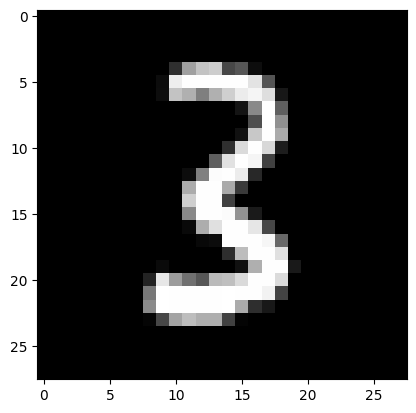

In [72]:
plt.imshow(xb[0].view(28,28))
yb[0].item()

Now we simplify the `fit` function to just loop `for xb,yb in train_dl`. 
And it still works  the same way. 

In [73]:
model,opt = get_model()

In [74]:
def fit():
    for epoch in range(epochs):
        for xb,yb in train_dl:
            preds = model(xb)
            loss = loss_func(preds, yb)
            loss.backward()
            opt.step()
            opt.zero_grad()
        report(loss, preds, yb)

In [75]:
fit()
#loss_func(model(xb), yb).item(), accuracy(model(xb), yb).item()

0.321, 0.938
0.215, 0.938
0.183, 0.938


### Random sampling
For better training, our dataset should be processed in a randomized order each epoch. The `Sampler` class handles this: it iterates through indices 0 to n, either sequentially (default) or randomly shuffled (`shuffle=True`).
But the validation set shouldn't be randomized.

In [76]:
import random

In [77]:
class Sampler():
    def __init__(self, ds, shuffle=False): 
        self.n,self.shuffle = len(ds),shuffle
    def __iter__(self):
        res = list(range(self.n))
        if self.shuffle: random.shuffle(res)
        return iter(res)

Below `sws` is a sampler **without** shuffle. 
We make an iterator `it` from `sws` and print a few things, it's just printing out the indexes.

In [78]:
sws = Sampler(train_ds)

it = iter(sws)
for o in range(5): print(next(it))

0
1
2
3
4


Or we can do the same thing using islice, to grab the first five things from a sampler when it's not shuffled, just indexes.  

In [79]:
from itertools import islice

list(islice(sws, 5))

[0, 1, 2, 3, 4]

When we add `shuffle=True`, it calls `random.shuffle()`, which (pseudo-)randomly permuts them. 
Below we've got 5 (pseudo)random indexes of the source data.  

In [80]:
ss = Sampler(train_ds, shuffle=True)
list(islice(ss, 5))

[26895, 24627, 6693, 9828, 28677]

Why is this useful? We define `BatchSampler` to perform batching using islice. It accepts a `sampler` (index generator) and a batch_size (`bs`), and then yields iterators of index batches with size `bs`.
<br>
We put Fastcore's `fc.store_attr()` in `__init__`, as a one line of code to store all the attributes.
`fc.chunked(it, chunk_sz=None, drop_last=False, n_chunks=None)`
return batches from iterator `it` of size `chunk_sz` (or return `n_chunks` total)

In [81]:
import fastcore.all as fc

class BatchSampler():
    def __init__(self, sampler, bs, drop_last=False): fc.store_attr()

    def __iter__(self): yield from fc.chunked(iter(self.sampler), self.bs, drop_last=self.drop_last)

Using `BatchSampler`, we can group indices from the Sampler `ss` into batches of 4. 
Each iteration will then output a sequence of four indices, enabling batch processing of the data.

In [82]:
batchs = BatchSampler(ss, 4)
list(islice(batchs, 5))

[[15838, 6279, 33799, 12615],
 [40574, 1937, 14529, 49351],
 [14232, 32528, 38729, 48034],
 [46686, 14959, 13852, 29468],
 [8767, 34273, 25075, 12773]]

`collate(b)` takes a batch `b` of data points, where each data point is a tuple (x, y).
`xs, yz = zip(*b)` "unzips" the batch, grouping the x values together and the y values together into tuples `xs` and `ys`.
`torch.stack()` converts the tuples into PyTorch tensors.

In [83]:
def collate(b):
    xs,ys = zip(*b)
    return torch.stack(xs),torch.stack(ys)

Let's use the `train_ds` to create a `t_samp` sampler, and then go through each thing in it. 

In [84]:
t_samp = BatchSampler(Sampler(train_ds, shuffle=False), bs)

Let's grab one output thing `o` from `t_samp` the BatchSampler. 
`o` contains `bs` (64) indeces in order. 

In [85]:
o = next(iter(t_samp))
len(o), o[:20]

(64, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19])

If we did a training sampler, `t2_samp` with `shuffle=True` that order would be randomized.

In [86]:
t2_samp = BatchSampler(Sampler(train_ds, shuffle=True), bs)
o2 = next(iter(t2_samp))
len(o2), o2[:10]

(64, [11224, 46164, 3986, 7288, 49889, 32859, 47806, 48259, 36943, 37375])

What did the BatchSampler produced? 

In [87]:
print(f"the output of the BatchSampler is a", {type(o)}, f"of length {len(o)} of", type(o[0]))

the output of the BatchSampler is a {<class 'list'>} of length 64 of <class 'int'>


The new Dataloader does
```python
def __iter__(self): 
    yield from (self.collate_fn(self.ds[i] for i in b) for b in self.batchs)
```
Lets explore what is `self.ds[i] for i in b`. 

In [88]:
p = [train_ds[i] for i in o]
type(p), len(p), type(p[0])

(list, 64, tuple)

`p[0]` is a tuple. 
It's got  the `x` (image) and the `y` (independent variable), which is not what we want. 
What we want is something that we can loop through. We want to get batches. 

In [89]:
p[0][1], len(p[0][0])

(tensor(5), 784)

The `collate` function combines batches of x and y values into two tensors. 
It uses Python's `zip()` function to transpose the data, grouping x values together and y values together. 
Specifically, `xs, ys = zip(*batch)` aggregates the values, which are then stacked to form tensors for the batch.
`zip()` aggregates elements from multiple iterables, making it useful for tasks like creating dictionaries or, in this case, collating data for batches.

In [90]:
xs,ys = zip(*p)

In [91]:
xs[0][0]

tensor(0.)

In [92]:
torch.stack(ys)

tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0, 9, 1, 1, 2, 4, 3, 2, 7, 3, 8, 6, 9, 0, 5, 6, 0, 7, 6, 1, 8, 7, 9,
        3, 9, 8, 5, 9, 3, 3, 0, 7, 4, 9, 8, 0, 9, 4, 1, 4, 4, 6, 0])

We modify the `DataLoader` to use a `BatchSampler`, which provides indices for each batch. 
The `DataLoader` then retrieves the corresponding dataset items for each index, resulting in a list. 
Finally, the collate function is used to combine the x and y values into tensors.

In [93]:
#Todo HW Experiment with these to see what everything is taking in
class DataLoader():
    def __init__(self, ds, batchs, collate_fn=collate): fc.store_attr()
    def __iter__(self): yield from (self.collate_fn(self.ds[i] for i in b) for b in self.batchs)

Now we can create a training/validation sampler, `train_samp`/`valid_samp` 
which is a batch sampler over the training/validation set with `shuffle=True/False.`

In [94]:
train_samp = BatchSampler(Sampler(train_ds, shuffle=True ), bs)
valid_samp = BatchSampler(Sampler(valid_ds, shuffle=False), bs)

Now we can pass those samplers (`train_samp` and `valid_samp`) into the `DataLoader` class, to create `train_dl` and `valid_dl`.  

In [95]:
train_dl = DataLoader(train_ds, batchs=train_samp)
valid_dl = DataLoader(valid_ds, batchs=valid_samp)

We do as before `xb, yb, next, iter`, and this time we use `valid_dl`.

tensor(3)

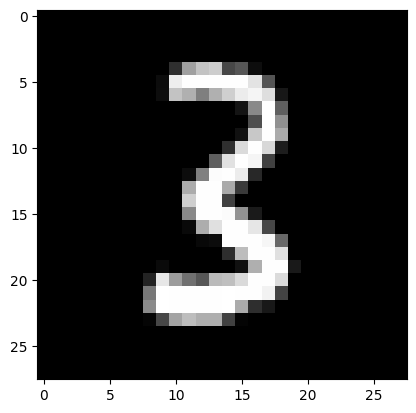

In [96]:
xb,yb = next(iter(valid_dl))
plt.imshow(xb[0].view(28,28))
yb[0]

We just check the shapes. 
This is how PyTorch's DataLoader works, all the pieces they have. 
They have  samplers, batch samplers, a collation function and  DataLoaders. <br>
Homework: Experiment with these carefully to see what each thing's taking in.

In [97]:
xb.shape,yb.shape

(torch.Size([64, 784]), torch.Size([64]))

In [98]:
model,opt = get_model()
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

0.200, 0.875
0.165, 0.938
0.064, 1.000


(tensor(0.09, grad_fn=<NllLossBackward0>), tensor(0.95))

### Multiprocessing DataLoader
PyTorch's DataLoader includes considerable code to enable multi-processing. This is crucial for parallelizing per-item batch operations like image loading and augmentation. Because Python's built-in multiprocessing library has limitations with PyTorch tensors, 
PyTorch offers its own multi-processing solution with the same API but optimized for tensor handling. 
This is not "cheating"; multi-processing is in the Python standard library, and this is API equivalent, so we can use it.  

In [99]:
import torch.multiprocessing as mp
from fastcore.basics import store_attr

When we call square brackets `[]` on a class, it's calling the `__getitem__` function on the object. 
If we say, give me some items (e.g., 3, 6, 8, and 1),  it's the same as calling `__getitem__` passing in 3, 6, 8, and 1.  

In [100]:
train_ds[[3,6,8,1]]

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([1, 1, 1, 0]))

In [101]:
train_ds.__getitem__([3,6,8,1])

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([1, 1, 1, 0]))

`map` is the other key piece of "map-reduce".
`map` takes a sequence and calls a function on every element of that sequence. 
Given a couple of batches of indices, e.g., `[3,6]` and `[8,1]`, we call` __getitem__`  on each of those batches. 
So its going to give us the same stuff, but now batched into two batches. 

In [102]:
for o in map(train_ds.__getitem__, ([3,6],[8,1])): print(o)

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]), tensor([1, 1]))
(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]), tensor([1, 0]))


multiprocessing (mp) 
enables parallel execution using `mp.Pool` to manage worker processes. Its `pool.map` function allows parallel application of a function to an iterator's items, analogous to Python's `map`. This parallel processing is key to building a multiprocessing DataLoader.

In [103]:
class DataLoader():
    def __init__(self, ds, batchs, n_workers=1, collate_fn=collate): fc.store_attr()
    def __iter__(self):
        with mp.Pool(self.n_workers) as ex: yield from ex.map(self.ds.__getitem__, iter(self.batchs))

`train_dl` below is a multiprocessing DataLoader, with `n_workers=2`.
We don't pass in the collate function because we're using the default one.

In [104]:
train_dl = DataLoader(train_ds, batchs=train_samp, n_workers=2)
it = iter(train_dl)

Calling `next()` introduces a short latency as two background workers are initialized. This initial overhead may cause the first batch to be slower. However, once the workers are active, the overall throughput for subsequent batches will be significantly improved.

In [105]:
xb,yb = next(it)
xb.shape,yb.shape

(torch.Size([64, 784]), torch.Size([64]))

### PyTorch DataLoader
Instead of a single sampler, Pytorch has two separate classes: `SequentialSampler` and `RandomSampler`,
and they've got BatchSampler.

In [106]:
#|export
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler, BatchSampler

The training (validation) sampler is a BatchSampler with a RandomSampler (SequentialSampler).
We define the samplers, `train_samp` and `valid_samp` passing them in batch sizes `bs`. 

In [107]:
train_samp = BatchSampler(RandomSampler(train_ds),     bs, drop_last=False)
valid_samp = BatchSampler(SequentialSampler(valid_ds), bs, drop_last=False)

We can now pass those samplers to the PyTorch’s DataLoader. 
It also takes a collate function, works the same as ours with the same API.

In [108]:
train_dl = DataLoader(train_ds, batch_sampler=train_samp) #, collate_fn=collate)
valid_dl = DataLoader(valid_ds, batch_sampler=valid_samp) #, collate_fn=collate)

In [109]:
model,opt = get_model()
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

0.217, 0.938
0.161, 1.000
0.012, 1.000


(tensor(0.13, grad_fn=<NllLossBackward0>), tensor(0.95))

Some shortcuts, e.g., we can just pass the batch size directly to a DataLoader, 
and it will auto-create the batchsamplers, so we don't have to pass in BatchSampler. 
Instead we just say `sampler=`, and it will  automatically wrap that in the batchsampler. 

PyTorch can auto-generate the BatchSampler for us:

In [110]:
train_dl = DataLoader(train_ds, bs, sampler=RandomSampler(train_ds)) #, collate_fn=collate)
valid_dl = DataLoader(valid_ds, bs, sampler=SequentialSampler(valid_ds)) #, collate_fn=collate)

Because it's common to create  a RandomSampler or a SequentialSampler for a Dataset, 
we can just pass in `shuffle=True` or `shuffle=False` to the DataLoader,
and PyTorch generates the Sequential/RandomSamplers too:

In [111]:
train_dl = DataLoader(train_ds, bs, shuffle=True, drop_last=True, num_workers=2)
valid_dl = DataLoader(valid_ds, bs, shuffle=False, num_workers=2)

In [112]:
model,opt = get_model()
fit()

loss_func(model(xb), yb), accuracy(model(xb), yb)

0.115, 0.984
0.174, 0.953
0.036, 1.000


(tensor(0.04, grad_fn=<NllLossBackward0>), tensor(0.98))

The `BatchSampler` provides pre-collated batches of indices, which can be directly used by the DataLoader. 
Since datasets support retrieving multiple indices at once, we can pass the BatchSampler as a sampler, 
eliminating the need for manual looping and collation.

**TODO**: understand how we can pass a BatchSampler to sampler and what's it doing.
For this, lets go back to our non-multi-processing pure Python code to see how that would work. 
It's a nifty trick to grab multiple things at once and it can save time, make code faster. 

In [113]:
train_ds[[4,6,7]]

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([9, 1, 3]))

...that means that we can skip the `batch_sampler` and `collate_fn` entirely:

In [114]:
train_dl = DataLoader(train_ds, sampler=train_samp)
valid_dl = DataLoader(valid_ds, sampler=valid_samp)

In [115]:
xb,yb = next(iter(train_dl))
xb.shape,yb.shape

(torch.Size([1, 64, 784]), torch.Size([1, 64]))

## Validation


You **always** should also have a [validation set](http://www.fast.ai/2017/11/13/validation-sets/), in order to identify if you are overfitting.<br>
We will calculate and print the validation loss at the end of each epoch.
<br>
(Note that we always call `model.train()` before training, and `model.eval()` before inference, because these are used by layers such as `nn.BatchNorm2d` and `nn.Dropout` to ensure appropriate behaviour for these different phases.)

The first part of `fit` is the same code as before.
Then we add a `for xb,yb in valid_dl` which goes through the validation set,
gets the predictions `pred`, sums up the losses and accuracies,
and prints the loss and accuracy. 

In [116]:
#|export
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb,yb in train_dl:
            loss = loss_func(model(xb), yb)
            loss.backward()
            opt.step()
            opt.zero_grad()

        model.eval()
        with torch.no_grad():
            tot_loss,tot_acc,count = 0.,0.,0
            for xb,yb in valid_dl:
                pred = model(xb)
                n = len(xb)
                count += n
                tot_loss += loss_func(pred,yb).item()*n
                tot_acc  += accuracy (pred,yb).item()*n
        print(epoch, tot_loss/count, tot_acc/count)
    return tot_loss/count, tot_acc/count

`get_dls()` uses the PyTorch DataLoader to create training and validation loaders, using 
the training and validation datasets.
Notice that for the validation DataLoader, we double the `batch_size`,
as it doesn't have to do backpropagation, it should use about half the memory, so we can use a bigger batch size.

In [117]:
#|export
def get_dls(train_ds, valid_ds, bs, **kwargs):
    return (DataLoader(train_ds, batch_size=bs, shuffle=True, **kwargs),
            DataLoader(valid_ds, batch_size=bs*2, **kwargs)) # double bs because it does not need to do backprop

Now, our whole process of obtaining the data loaders and fitting the model can be run in 3 lines of code:

In [118]:
train_dl,valid_dl = get_dls(train_ds, valid_ds, bs)
model,opt = get_model()
loss,acc = fit(5, model, loss_func, opt, train_dl, valid_dl)

0 0.1752694676682353 0.9497
1 0.1467677358612418 0.9563
2 0.20965449111163617 0.9341
3 0.11569483358860017 0.9662
4 0.18093234625775367 0.9536


And now it's printing out the loss and accuracy on the **validation** set.
(Finally we actually know accuracy on the whole validation set.)
**We've now implemented a working training loop, where every line of code is calling stuff that we have implemented.**

%pip install -q nbdev

In [119]:
import nbdev; nbdev.__version__

'2.4.2'

In [120]:
nbdev.nbdev_export()